In [241]:
import re
import datetime

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from itertools import chain
from collections import Counter

from reviews.config import (
    processed_data_dir
)

from reviews.config import out_dir, asum_output_dir

# Models Comparison

In [242]:
total_df = pd.DataFrame()
for n_topics in [10, 20, 30, 50]:
    for model in ["asum", "jst"]:
        for norm in ["raw", "stemming", "lemmatization"]:

            filename = out_dir / model / f"metrics_{model}_{n_topics}_text_{norm}.csv"

            if not filename.exists():
                continue

            df = pd.read_csv(filename)
            df["model"] = model
            df["normalization"] = norm

            total_df = pd.concat((df, total_df))


In [243]:
total_df[total_df['model'] == 'asum'].groupby(['normalization', 'n_topics'])[
    ['f1_macro', 'f1_weighted', 'f1_micro']].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
lemmatization 10        0.610995     0.822938  0.783224
              20        0.609943     0.825730  0.787974
              30        0.609353     0.826766  0.789831
              50        0.615289     0.832343  0.797935
raw           10        0.603015     0.819242  0.778656
              20        0.604509     0.824062  0.786347
              30        0.604621     0.825871  0.789284
              50        0.614762     0.835591  0.803572
stemming      10        0.626172     0.836788  0.803171
              20        0.619642     0.831365  0.795388
              30        0.619473     0.834202  0.800157
              50        0.626493     0.841002  0.810205

In [244]:
total_df[total_df['model'] == 'jst'].groupby(['normalization', 'n_topics'])[
    ['f1_macro', 'f1_weighted', 'f1_micro']].mean()

f1_macro  f1_weighted  f1_micro
normalization n_topics                                 
stemming      10        0.563276     0.764685  0.702036
              20        0.557473     0.757249  0.692407
              30        0.558806     0.757243  0.692017
              50        0.559091     0.761021  0.697063

(0.55, 0.65)

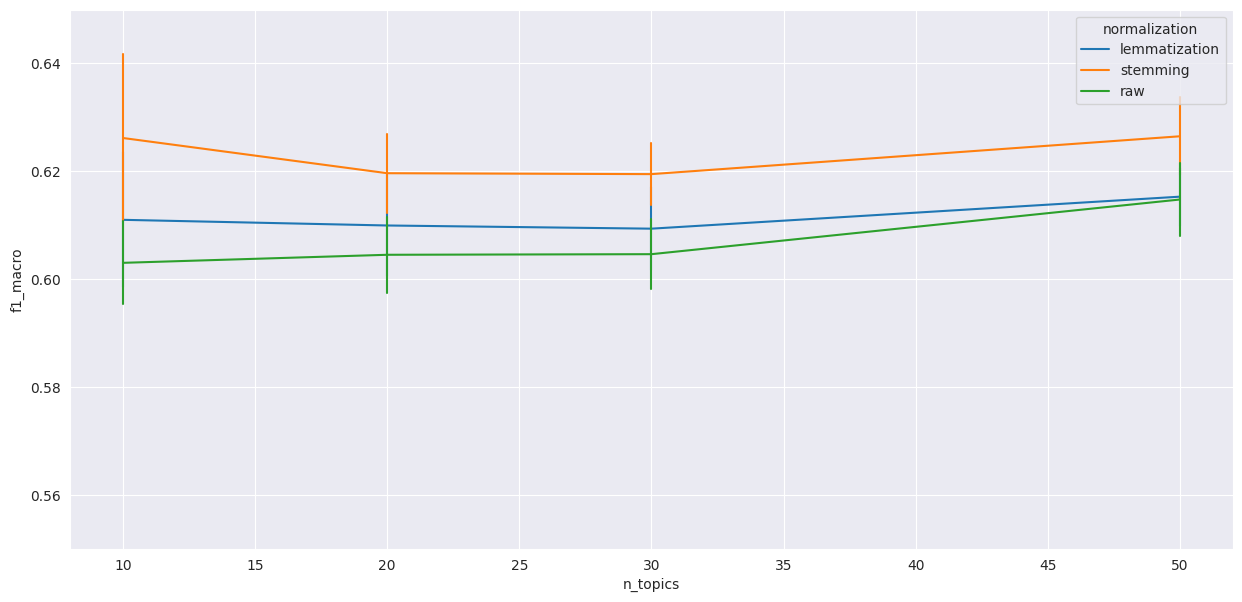

In [245]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(total_df[total_df['model'] == 'asum'], y="f1_macro", x="n_topics", hue="normalization", ax=ax,
             err_style="bars", errorbar="sd")
ax.set_ylim([0.55, 0.65])

(0.5, 0.65)

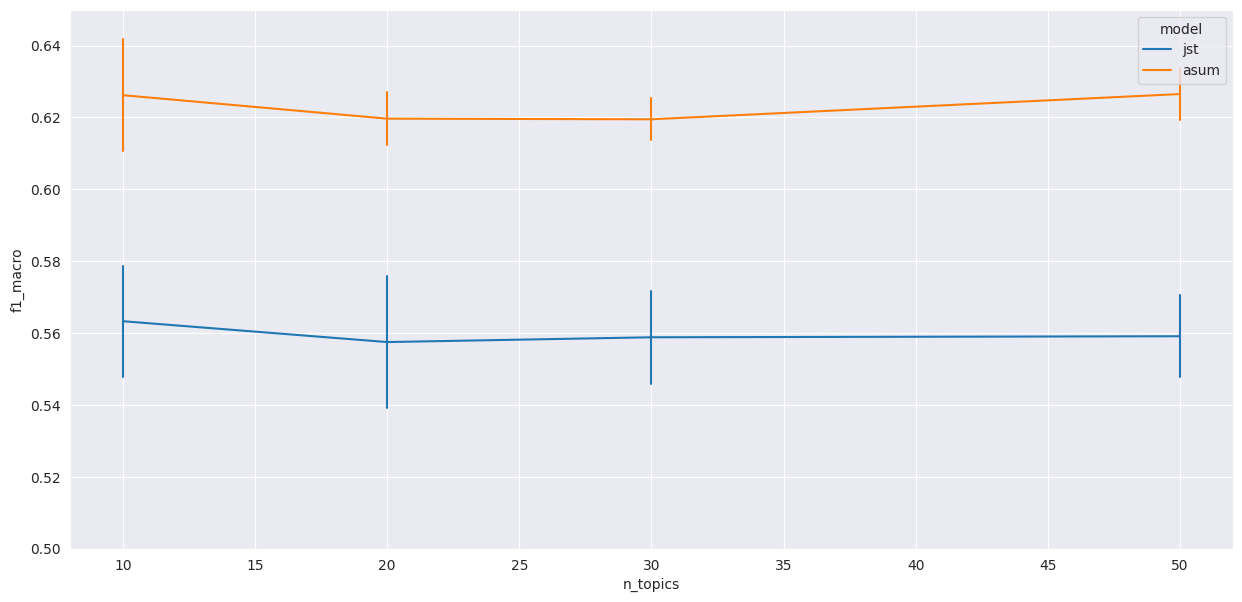

In [246]:
fig, ax = plt.subplots(figsize=(15, 7))
sns.lineplot(total_df[total_df['normalization'] == 'stemming'], y="f1_macro", x="n_topics", hue="model", ax=ax,
             err_style="bars", errorbar="sd")
ax.set_ylim([0.5, 0.65])

# ASPECT BASED SENTIMENT ANALYSIS (ASUM)

In [247]:
NORM = "stemming"  # stemming, lemmatization
FIELD = "text"  # text, text+summary

In [248]:
n_runs = 10
n_topics = 50
iterations = 1000

alpha = 0.1  # 50 / n_topics # 0.1
beta = [0.001, 0.1, 0]
gamma = [1, 1]

# Read Reviews Data

In [249]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x]))  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(lambda x: [sent for sent in x if len(sent) <= 50])

Too Long Reviews: 0.50%
Empty Reviews: 0.05%


In [250]:
filename_prefix = f"STO2-T{n_topics}-S2(2)-A{alpha}-B{','.join([f'{float(x)}' for x in beta])}-G{','.join([f'{float(x):.1f}' for x in gamma])}-I{iterations}"

## PI = documents x sentiment

In [251]:
pi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Pi.csv", header=None)

## PHI = vocabulary x senti aspects

In [252]:
phi_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Phi.csv")
phi_df.sort_values(by="S1-T1", ascending=False, inplace=True)

## THETA = documents x senti aspects


In [253]:
def map_topic_sentiment(column_name):
    if "Unnamed" in column_name:
        return None

    values = column_name.split("-")
    return {
        "sentiment": int(values[0][1]),
        "topic": int(values[1][1:]),
        "colname": column_name,
    }


theta_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-Theta.csv")
theta_df.drop(columns=[f"Unnamed: {n_topics * 2}"], inplace=True)

In [254]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

Reviews without topics:  165


In [255]:
(f_theta_df > T).sum(axis=1).describe()

count    28818.000000
mean         1.630370
std          0.909301
min          0.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          6.000000
dtype: float64

In [256]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

0         [S0-T9, S0-T32]
1        [S0-T30, S1-T34]
2        [S0-T14, S1-T30]
3                [S0-T29]
4                [S1-T33]
               ...       
28978    [S0-T24, S0-T27]
28979            [S0-T33]
28980             [S0-T0]
28981             [S1-T1]
28982            [S0-T23]
Length: 28983, dtype: object

In [257]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
#reviews_df.to_json(asum_output_dir / "topics.json", orient="records")
reviews_df["topics"]

0        [{'sentiment': 0, 'topic': 9, 'colname': 'S0-T...
1        [{'sentiment': 0, 'topic': 30, 'colname': 'S0-...
2        [{'sentiment': 0, 'topic': 14, 'colname': 'S0-...
3        [{'sentiment': 0, 'topic': 29, 'colname': 'S0-...
4        [{'sentiment': 1, 'topic': 33, 'colname': 'S1-...
                               ...                        
28978    [{'sentiment': 0, 'topic': 24, 'colname': 'S0-...
28979    [{'sentiment': 0, 'topic': 33, 'colname': 'S0-...
28980    [{'sentiment': 0, 'topic': 0, 'colname': 'S0-T...
28981    [{'sentiment': 1, 'topic': 1, 'colname': 'S1-T...
28982    [{'sentiment': 0, 'topic': 23, 'colname': 'S0-...
Name: topics, Length: 28983, dtype: object

## ProbWords

In [258]:
prob_words_df = pd.read_csv(asum_output_dir / f"{filename_prefix}-ProbWords.csv")
columns = prob_words_df.columns.map(map_topic_sentiment)

In [259]:
def get_word_weight(text):
    match = re.match("(\w+)\s+\((.*?)\)", text)
    if match is None:
        print(text)
    word, weight = match.groups()
    return word, float(weight)


def plot_prob_words():
    n_top_words = 20
    total_df = pd.DataFrame()

    fig, axes = plt.subplots(int(n_topics / 10 * 2), 10, figsize=(50, 50))
    for idx, item in enumerate(columns):
        if item is None:
            continue

        ax = axes[
            int(int(item["topic"] / 10) * 2 + item["sentiment"]), int(item["topic"] % 10)
        ]
        words = prob_words_df[item["colname"]][:n_top_words]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        w = weights.copy()
        w["colname"] = item["colname"]
        total_df = pd.concat((total_df, w))

        ax.barh(weights["names"], weights["weights"], height=0.5)
        ax.set_title(item["colname"])

        ax.set_xlabel(f"Topic {item['topic'] + 1}")
        ax.set_ylabel("Positive" if item["sentiment"] == 0 else "Negative")

    fig.tight_layout()

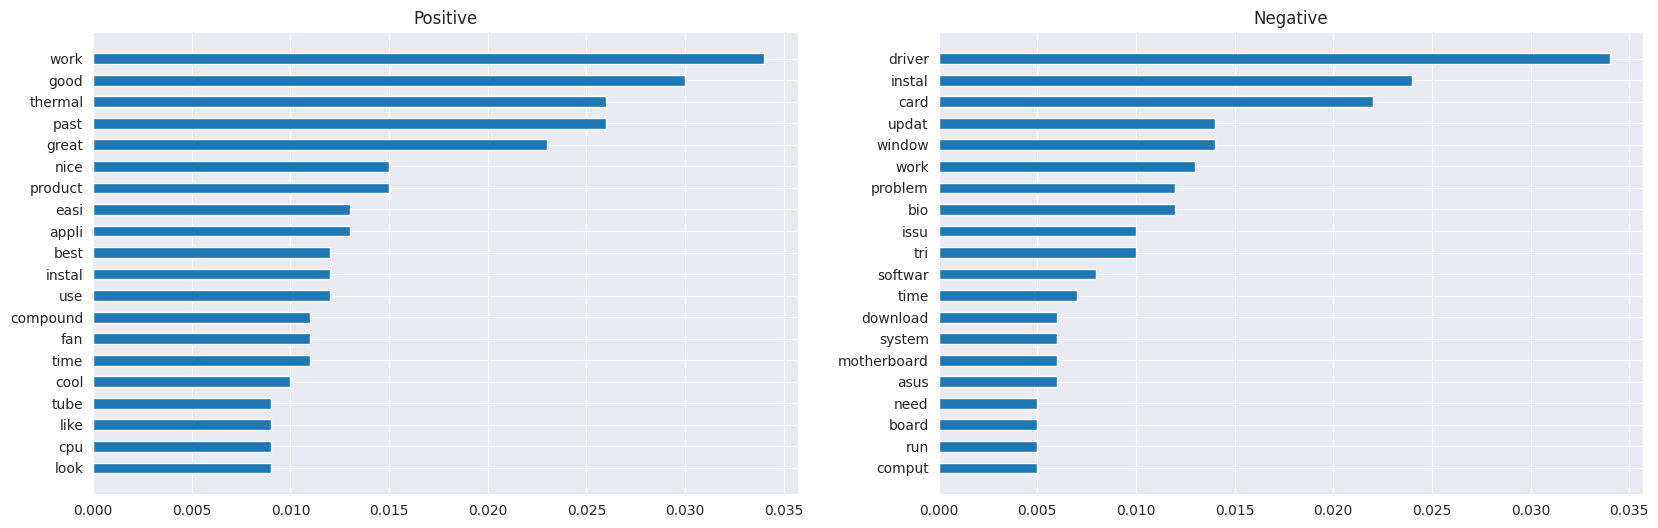

In [260]:
def show_topic(topic, n=20):
    fig, axes = plt.subplots(1, 2, figsize=(20, 6), sharex=True)
    axes = axes.flatten()

    for s in range(2):
        words = prob_words_df[f"S{s}-{topic}"][:n]
        weights = list(map(list, zip(*words.map(get_word_weight))))

        weights = pd.DataFrame({"names": weights[0], "weights": weights[1]})
        weights.sort_values("weights", inplace=True)

        axes[s].barh(weights["names"], weights["weights"], height=0.5)
        axes[s].set_title("Positive" if s == 0 else "Negative")


def print_examples(topic, k=5):
    ddf = reviews_df.copy()
    ddf["topics"] = ddf["topics"].apply(lambda x: set([y['colname'] for y in x]))

    pos_examples = pd.Series([row['text'] for i, row in ddf.iterrows() if f"S0-{topic}" in row["topics"]]).sample(k)
    neg_examples = pd.Series([row['text'] for i, row in ddf.iterrows() if f"S1-{topic}" in row["topics"]]).sample(k)

    print("Positive ---------------------------------------------------------------------------------\n")
    [print(">----------\n", ex) for ex in pos_examples]


    print("\nNegative ---------------------------------------------------------------------------------")
    [print(">----------\n", ex) for ex in neg_examples]


topic_mapping = {
    "T0": "recommended",
    "T1": "gaming",
    "T2": "performance",
    "T3": "drivers",
    "T4": "graphic card",
    "T5": "motherboard",
    "T6": "build",
    "T7": "temperature",
    "T8": "price",
    "T9": "quality",
    "T10": "storage",
    "T11": "motherboard",
    "T12": "graphic card",
    "T13": "brand",
    "T14": "memory",
    "T15": "cooling system",
    "T16": "motherboard",
    "T17": "installation",
    "T18": "performance",
    "T19": "monitor",
    "T20": "cooling system",
    "T21": "quality",
    "T22": "motherboard",
    "T23": "power supply system",
    "T24": "service",
    "T25": "installation",
    "T26": "case",
    "T27": "build",
    "T28": "cooling system",
    "T29": "power supply system",
    "T30": "aesthetic",
    "T31": "cooling system",
    "T32": "sound card",
    "T33": "motherboard",
    "T34": "thermal paste",
    "T35": "recommended",
    "T36": "pc replacement / upgrade",
    "T37": "price",
    "T38": "audio/video cards",  # ..........
    "T39": "service",
    "T40": "price",
    "T41": "service",
    "T42": "memory",
    "T43": "gaming",
    "T44": "cooling system",
    "T45": "processor",
    "T46": "memory",
    "T47": "processor",
    "T48": "recommended",
    "T49": "network",
}


topic = "T34"
show_topic(topic, n=20)

In [261]:
print_examples(topic)

Positive ---------------------------------------------------------------------------------

>----------
 Very good paste. In fact, it only takes me like 1/10 of it to cover the whole CPU and keep my system cool. No problem so far.
>----------
 I decided to replace the GT 545 card from the Alienware x51 for this card.
I got a used one but it was in perfect conditions and even with all the extras that come in the package.
Installation was a breeze, no complications at all.

This card is just amazing, perhaps I am excited because this is the first high end card I have had. It runs even modern games at a very good and high speed and very cool temperatures.

This card is one of the best in the market while looking Price vs Performance, so it gives a lot for the buck.

Pros: Excellent price vs Performance, Excellent iddle (35C) and load (65) temperatures, Very good build quality, Very easy to install, Runs games at excellent speeds.
Cons: None I can think of.
>----------
 excellent product a

## Sentiment

In [262]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == 0 else "negative")
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

### Sentiment Over Time

In [263]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics

In [308]:
count = Counter()
for x in reviews_df["topics"].values:
    topics = set(["T" + str(y["topic"]) for y in x])
    count.update(topics)

topics_count = pd.DataFrame(count.items(), columns=["topic", "count"])
topics_count["topic"] = topics_count["topic"].apply(lambda x: topic_mapping[x]).astype("category")

topics_count = pd.DataFrame(topics_count.groupby('topic')['count'].sum()).reset_index()
order = topics_count.sort_values(by="count", ascending=False)
order = order.reset_index()["topic"]

fig1 = px.bar(
    topics_count,
    y="topic",
    x="count",
    color_discrete_sequence=["#108de4"],
    category_orders=dict(topic=order),
    height=1000,
    width=1200
)
fig1.update_xaxes(showgrid=False, title_text="")
fig1.update_yaxes(showgrid=False, title_text="")
fig1.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})
fig1

In [337]:
pos_count = Counter()
neg_count = Counter()

for t in reviews_df["topics"].values:
    pos_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 0])
    neg_topics = set([f"T{s['topic']}" for s in t if s["sentiment"] == 1])

    pos_count.update(pos_topics)
    neg_count.update(neg_topics)

pos_df = pd.DataFrame(pos_count.items(), columns=["topic", "pos"])
neg_df = pd.DataFrame(neg_count.items(), columns=["topic", "neg"])

pos_df["topic"] = pos_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
pos_df = pd.DataFrame(pos_df.groupby('topic')['pos'].sum()).reset_index()

neg_df["topic"] = neg_df["topic"].apply(lambda x: topic_mapping[x]).astype("category")
neg_df = pd.DataFrame(neg_df.groupby('topic')['neg'].sum()).reset_index()

st_counts = pd.merge(pos_df, neg_df, on="topic")
st_counts["topic"] = st_counts["topic"].astype("category")

total = st_counts["pos"] + st_counts["neg"]
st_counts["pos"] = st_counts["pos"] / total * 100
st_counts["neg"] = st_counts["neg"] / total * 100

st_counts.set_index("topic", inplace=True)
st_counts.sort_index(inplace=True)

df_senti = (
    st_counts.stack(level=0)
    .reset_index()
    .rename(columns={"level_1": "sentiment", 0: "count"})
)

fig2 = px.bar(
    df_senti,
    y="topic",
    x="count",
    color="sentiment",
    color_discrete_sequence=["#f54242", "#27d957"],
    barmode="relative",
    category_orders=dict(topic=order),
)

fig2.update_xaxes(showgrid=False, title_text="")
fig2.update_yaxes(showgrid=False, title_text="")
fig2.update_layout({"margin": dict(l=0, t=0, r=0, b=0)})

# ASPECT BASED SENTIMENT ANALYSIS (JST)

In [ ]:
NORM = "stemming"
FIELD = "text"

n_runs = 10
n_topics = 50
iterations = 1000

alpha = -1
beta = -1
gamma = -1

# Read Reviews Data

In [ ]:
# load tokens
reviews_df = pd.read_json(processed_data_dir / f"reviews_{FIELD}_{NORM}.json.gz")

too_long = reviews_df["tokens"].apply(
    lambda x: any([len(sent) > 50 for sent in x]))  # len(list(chain.from_iterable(x))) > 50
empty = reviews_df["tokens"].apply(lambda x: len(list(chain.from_iterable(x))) == 0)

print(f"Too Long Reviews: {too_long.sum() / len(reviews_df) * 100:.2f}%")
print(f"Empty Reviews: {empty.sum() / len(reviews_df) * 100:.2f}%")

reviews_df["tokens"] = reviews_df["tokens"].apply(lambda x: [sent for sent in x if len(sent) <= 50])

In [ ]:
# columns name
columns_name = []

for x in range(2):
    for y in range(n_topics):
        columns_name.append("S" + str(x) + "-T" + str(y))

## PHI = vocabulary x senti aspects

In [ ]:
# prepare phi file for analysis
with open(out_dir / "jst" / "final.phi") as f:
    lines = f.readlines()

    phi = {}
    tmp = ""
    for i, line in enumerate(lines):
        if i % 2 != 0:
            phi[tmp] = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
        else:
            tmp = line.strip()

phi_df = pd.DataFrame(phi)
phi_df.columns = columns_name
phi_df

## PI = documents x sentiment

In [ ]:
# prepare pi file for analysis
pi_df = pd.read_csv(out_dir / "jst" / "final.pi", sep=" ", header=None)
pi_df.drop([0, 1, 4], axis=1, inplace=True)
pi_df.columns = ["S0", "S1"]
pi_df

## THETA = documents x senti aspects

In [ ]:
with open(out_dir / "jst" / "final.theta") as f:
    lines = f.readlines()

    theta = []
    tmp = []
    for i, line in enumerate(lines):
        if i % 3 != 0:
            values = [float(x.strip()) for x in line.split(" ") if x.strip() != ""]
            tmp.extend(values)
        else:
            if tmp:
                theta.append(tmp)
                tmp = []

theta_df = pd.DataFrame(theta, columns=columns_name)
theta_df

In [ ]:
f_theta_df = theta_df[theta_df.min(axis=1) != theta_df.max(axis=1)]
print("Reviews without topics: ", len(theta_df) - len(f_theta_df))

T = 0.15

In [ ]:
topics = (theta_df > T).apply(lambda x: list(theta_df.columns[x]), axis=1)
topics

In [ ]:
(f_theta_df > T).sum(axis=1).describe()

In [ ]:
reviews_df["topics"] = topics.apply(lambda x: list(map(map_topic_sentiment, x)))
reviews_df["topics"]

## Sentiment

In [ ]:
doc_sentiment = pi_df.idxmax(axis=1).map(lambda x: "positive" if x == "S0" else "negative")
reviews_df["sentiment"] = doc_sentiment

px.pie(
    reviews_df["sentiment"].value_counts(),
    values="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    names=["positive", "negative"],
    hole=0.65,
)

# Sentiment Over Time

In [ ]:
period = "M"
reviews_df[period] = reviews_df["timestamp"].dt.to_period(period)
reviews_df[period] = reviews_df[period].dt.to_timestamp()

sentiments_count = reviews_df.groupby(period)["sentiment"].value_counts()
sentiments_df = (
    pd.DataFrame(sentiments_count)
    .rename(columns={"sentiment": "count"})
    .reset_index()
)

fig = px.line(
    sentiments_df,
    x=period,
    y="count",
    color="sentiment",
    color_discrete_sequence=["#27d957", "#f54242"],
    title="Sentiment Over Time",
)
fig.update_xaxes(
    showgrid=False,
    title_text="",
    range=list(map(lambda x: datetime.datetime(x, 1, 1), [1999, 2018])),
)
fig.update_yaxes(showgrid=False, title_text="# Reviews")
fig.update_layout(margin=dict(l=0, r=0, b=0))

## Topics